# GreyNoise DataSci User Grouping Case Study
This is an example project for Data Science at GreyNoise

## Description
For this project we'd like you to take our business intelligence data and try to identify users that have similar patterns of use so we can better serve their needs. Included is a csv of mock api usage for a set of users over a 16 week period. There are five different types of APIs included, which should be considered different use cases (for this exercise the definitions don't matter, just that they are different and different users would use different combinations at different ammunts).

See: `user_api_data.csv`

## Goal
Your challenge is to find groups within this set that seem to have similar usage patterns. There are a lot of ways to slice this problem, so part of the task is to think about what you can do to turn this into cohesive groups.

## Deliverable
1. Initial thinking and plan of action. *This is the most important part.*
2. A csv of relevant groups found with their corresponding api usage metrics.
3. Some code (jupyter notebook, python script, javascript, go, or R) to reproduce your results. Don't worry about packaging imports or cleaning up file system references.
4. Afterthoughts and where you could go with more time.

## What we don't expect from you:
- Perfection
- More than two hours of effort
    - Completion is not the only metric.
    - Initial thoughts, partial code, and describing what you did is most important.
    - A well thought out plan is more important than a final result.




# Deliverable / Write up
## Initial thinking and plan of action
### Approach for this notebook
The plan for clustering was as follows:  
* Read in the data and make any necessary data type conversions
* Convert the raw time series data into aggregate features by API type and user_id
* Scale features to standardize distance for clustering calculations
* Split data by API type 
* Loop through multiple DBSCAN min_sample values and collect model performances
* Identify the best model based on silhouette score
* Plot input data by cluster label and api type
* Join the best model's labels into the input (feature engineered) dataset and original dataset

### Libraries Used
The libraries used for this analysis were numpy, pandas, collections, sklearn, matplotlib, and seaborn. Numpy and pandas were used for general data reading, manipulation, and calculating aggregate statistics during feature engineering. The collections library's Counter function was used during feature engineering as a shortcut for calculating value counts. Sklean was used for modeling with DBSCAN as well as minmax scaling of dataframe columns. Matplotlib and seaborn were used to plot model quality metrics and final cluster characteristics. 

### Feature Engineering
The following features were constructed from the raw time series input data:  
**Duration Based Features**  
* Total days used (use_days)
* Total duration of any usage (use_duration)
* Average duration of continuous usage (avg_cont_use)

**Usage Volume Features - Scaled to Whole Population**  
* Log10 of the sum of API Calls (total_calls_log10)
* Mean scaled usage (mean_usage_scaled)

**Usage Volume Features - Scaled Within User**  
* SD scaled usage (sd_usage_scaled)
* Range of usage (usage_range)

The duration based features show consistency and longevity of usage with the intention of separating sporadic vs. consistent users. The mean and SD scaled usage features also show consistency by demonstrating how much a single user varies their usage within an API. The log transformed sum of calls is intended to separate low vs high volume users since this feature was scaled across the population instead of within a single id. Log transformation was used due to a few high volume outliers skewing most other users too close to 0. 

Min-max scaling was used on all features to make distances standard during DBSCAN calculations and make the epsilon choice more clear. Two features - mean and SD scaled usage - ran into issues with zero division for users who only had 1 observation or never changed their API usage (max == min). In these cases, a custom min max scaler was written to provide 1 as a default option since the goal of these metrics was to measure consistency of usage and these users were consistent, albeit briefly. Defaulting to 0 would also work depending on the situation. 

### Results
DBSCAN appears to have struggled to identify many discrete groups. The most unique cluster labels identified was 3 including 1 label for obervations out of clusters. Despite the low number of clusters, the number of non-noise cluster observations was typically around 50% which indicates that approximately half of the users have some shared feature that may be useful for business intelligence. PArticularly, the final graphs in this notebook show some differences between the total log number of api calls and usage duration among the groups. With more time hypothesis testing on the group differences could be performed to allow business intelligence to focus on statistically significant results.

## Thoughts for going forward

My initial approach - not included in this notebook - was to cluster the data with minimal feature engineering using dynamic time warping and kmeans from the tslearn library. This method did not work out and had significant computational time requirements and was scrapped early into the trials. I believe this kmeans dtw approach deserves further investigation but it may need additional data preprocessing. If more time was available, I would have attempted additional preprocessing techniques such as log scaling, connecting discontinued sequences, or possibly standardizing/removing sequence gaps. 

In this notebook's analysis, I would have liked to engineer some additional features such as the slope of a line fit to the time series data or the number of usage peaks that a user exhibits but I was unsure of the appropriateness of these features without further subject matter expertise. I was also not entirely pleased with the duration based usage features due to the limitations of the input data. For example, the "Total days used" feature may be inaccurate if a user's activity extended beyond the provided time frame. 
For modeling, additional clustering techniques such as KMeans should be tried and the parameter values should be chosen more systematically. DBSCAN was used to avoid specifying a number of clusters and the parameter selection loop could be [1] written more cleanly using sklearn's gridsearchcv and [2] be expanded to include a search for optimal epsilon (eps) value which was chosen here as a result of trial and error based on the scale of the input features. 



In [1]:
# General Imports
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

# Modeling
from sklearn.cluster import DBSCAN
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Avoiding scientific notation and formatting floats with two decimal points for ease of reading.
pd.set_option('display.float_format', lambda x: '%.2f' % x)

seed=1
np.random.seed(seed)

In [2]:
data = pd.read_csv("./data/user_api_data.csv")
data["dt"] = pd.to_datetime(data["dt"])
data["user_id"] = data["user_id"].astype("object")
data.head()

,dt,user_id,type,api_count
0,2021-08-13,0,gnql,144
1,2021-08-13,1,gnql,2
2,2021-08-13,1,riot,1
3,2021-08-13,2,analysis,1
4,2021-08-13,2,gnql,4


In [3]:
def min_max_scale(x):
    """
    Basic min-max scaler with a default option to return 1 if min==max.
    """
    min_x = min(x)
    max_x = max(x)
    if min_x == max_x:
        return 1
    else: 
         return (x-min_x) / (max_x-min_x)
        
def avg_consecutive_dates(x):
    """
    Mean value of days in which an API was used continuously.
    """
    return np.mean(list(Counter(x.diff().dt.days.ne(1).cumsum().values).values()))

# Set up scaler to be used in the next cell
scaler = MinMaxScaler()

In [4]:
# Feature Engineering
agg_data = data.groupby(['user_id', 'type']).agg(
    # Duration Statistics 
    use_days = ('api_count', len),
    use_duration = ('dt', lambda x: (max(x) - min(x)).days),
    avg_cont_use = ('dt', lambda x: avg_consecutive_dates(x)),
    
    # Overall Usage 
    total_calls_log10 = ('api_count', lambda x: np.log10(sum(x))),
    usage_range = ('api_count', lambda x: max(x)-min(x)),

    # Mean Usage - scaled within feature creation to provide a default value (1) in the event of zero division
    mean_usage_scaled = ('api_count', lambda x: np.mean(min_max_scale(x))),
    sd_usage_scaled = ('api_count', lambda x: np.nan_to_num(np.std(min_max_scale(x))))

).reset_index()

unscaled_features = ['use_days','use_duration','usage_range', 'avg_cont_use', 'total_calls_log10']
agg_data[unscaled_features] = scaler.fit_transform(agg_data[unscaled_features])

agg_data.head()

,user_id,type,use_days,use_duration,avg_cont_use,total_calls_log10,usage_range,mean_usage_scaled,sd_usage_scaled
0,0,gnql,0.74,0.74,0.74,0.56,0.00,0.95,0.12
1,1,gnql,0.00,0.00,0.00,0.04,0.00,1.00,0.00
2,1,riot,0.00,0.00,0.00,0.00,0.00,1.00,0.00
3,2,analysis,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,2,gnql,0.03,0.15,0.00,0.22,0.00,0.28,0.42


## Modeling

In [5]:
model_metrics = []
best_models = []
agg_data_withLabels = []

for api in data.type.unique():
    # Subset to a single API
    api_data = agg_data[agg_data.type == api].copy()
    
    # Drop non input feature data
    x = api_data.drop(['user_id', 'type'], axis=1)

    # Create vectors to track the current API's best model and metrics
    api_model_metrics = []
    api_best_silhouette = -1

    # Loop through different values of min_samples
    for k in range(3, 25):
        model = DBSCAN(eps=.15, min_samples=k).fit(x)
        labels = model.labels_
        
        # Only proceed if the model was able to cluster (all -1 == all noise)
        if any(labels != -1):
            sil = silhouette_score(x, labels)
            api_model_metrics.append({'k':k, 'noise':list(labels).count(-1), 'silhouette':sil})
            
            model_metrics.append({'api':api, 'k':k, 'noise':list(labels).count(-1), 'silhouette':sil})

            # If model has improved, save it
            if sil > api_best_silhouette:
                api_best_model = model
                api_best_labels = labels
                api_best_k = k
                api_data['cluster_label'] = labels
        else:
            pass
    
    # Save the current API's best model to the global list with all other APIs
    best_models.append({'api':api, 'model':api_best_model, 'labels':api_best_labels})
    agg_data_withLabels.append(api_data)
    
    
# Convert model metrics list to dataframe
model_metrics_df = pd.DataFrame(model_metrics)

# Convert list of dataframes to single dataframe
agg_data_withLabels = pd.concat(agg_data_withLabels) 

## Joining Labels Data Back into Input Data
data_withLabels = pd.merge(data, agg_data_withLabels[['user_id', 'type', 'cluster_label']], how="left", on=['user_id', 'type'])

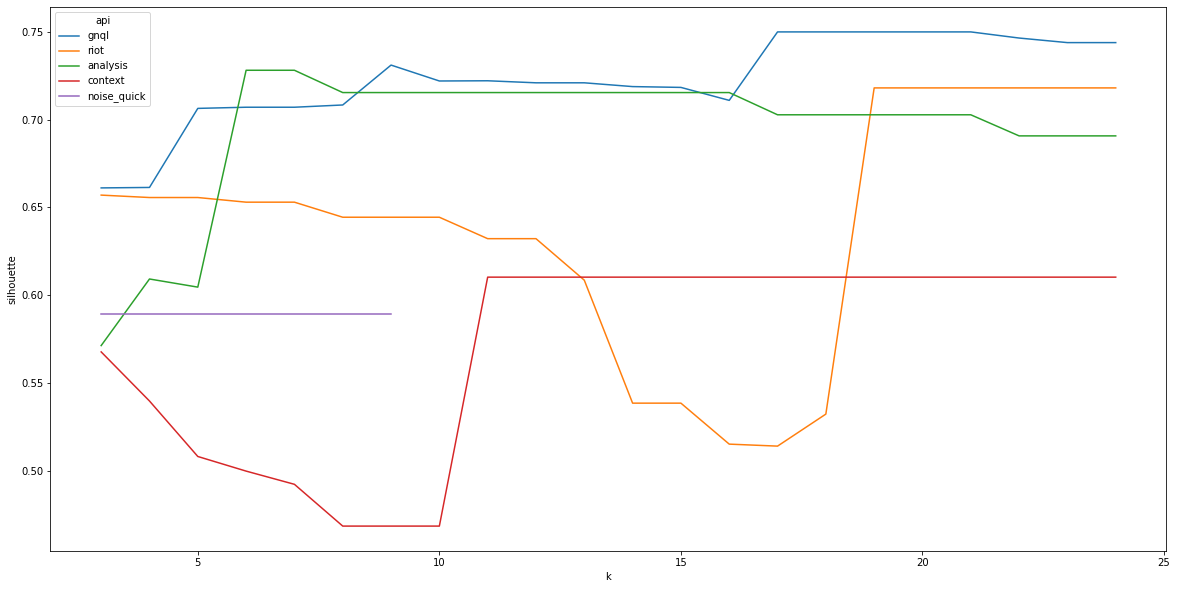

In [6]:
# Plotting silhouette scores
plt.figure(figsize=(20,10))
sns.lineplot(x='k', y='silhouette', hue='api', data=model_metrics_df)
plt.show()

## Description of Identified Clusters

type         cluster_label
analysis      0                71
             -1                35
context       0                46
             -1                44
gnql          0               331
              1               146
             -1                77
noise_quick  -1                12
              0                 9
riot          0                74
             -1                67
Name: cluster_label, dtype: int64


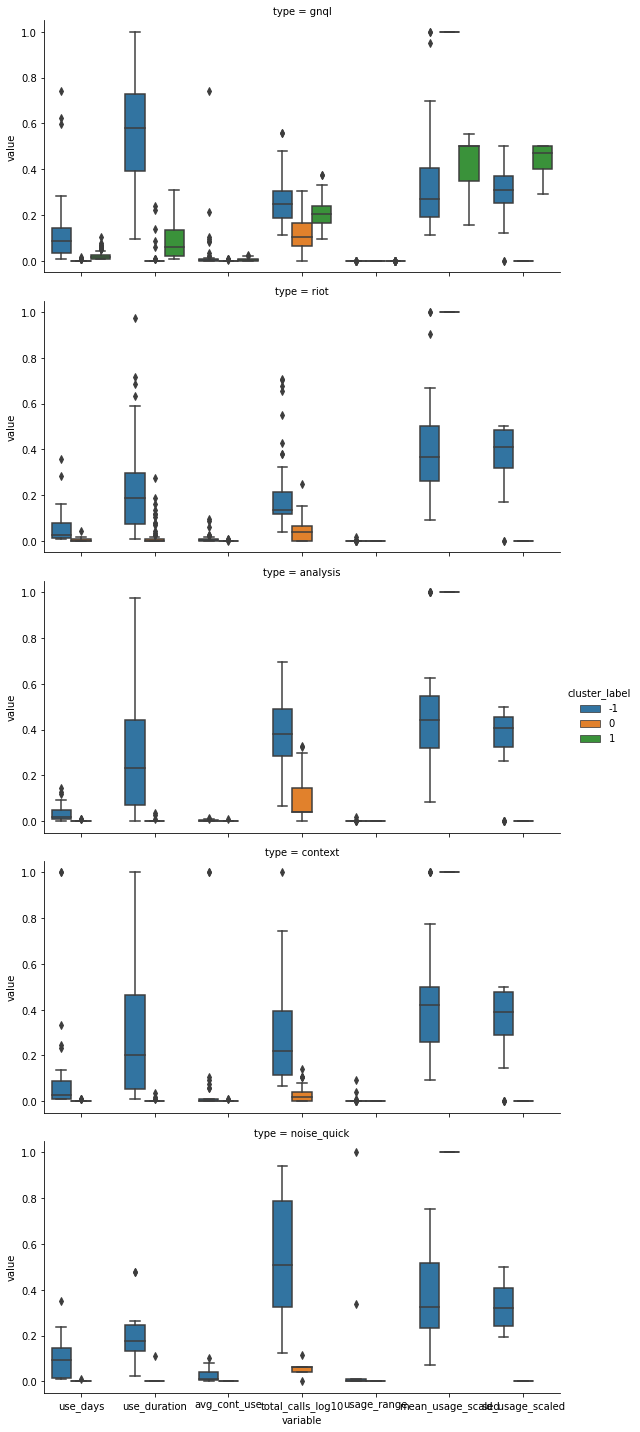

In [7]:
group_cols = ['type', 'cluster_label']
stat_cols = ['use_days', 'use_duration', 'avg_cont_use', 'total_calls_log10', 
             'usage_range', 'mean_usage_scaled', 'sd_usage_scaled']

# Convert data to long form
agg_data_long = agg_data_withLabels.drop('user_id', axis=1).melt(id_vars = group_cols)

print(agg_data_withLabels.groupby(['type']).cluster_label.value_counts())
# Plot each category by cluster and API type
sns.catplot(
    x='variable', y='value', 
    hue='cluster_label', row='type', 
    kind='box', height = 4, aspect = 2,
    data=agg_data_long)
plt.show()

## Writing Output

In [8]:
# Aggregated Input Features with Cluster Labels
agg_data_withLabels.to_csv('ip_cluster_labeled_input_features.csv')

# Raw Data  with Cluster Labels
data_withLabels.to_csv('ip_cluster_labeled_raw_data.csv')

In [10]:
!jupyter nbconvert --execute --to markdown travis_spear_ip_clustering_greynoise.ipynb

[NbConvertApp] Converting notebook travis_spear_ip_clustering_greynoise.ipynb to markdown
[NbConvertApp] Support files will be in travis_spear_ip_clustering_greynoise_files/
[NbConvertApp] Making directory travis_spear_ip_clustering_greynoise_files
[NbConvertApp] Making directory travis_spear_ip_clustering_greynoise_files
[NbConvertApp] Writing 23930 bytes to travis_spear_ip_clustering_greynoise.md
